In [1]:
import os
import time
import datetime
from pathlib import Path
import pandas as pd
import pyabf

# Steps to convert 1st set of ABF files
- read in metadata
- identify files to be converted (from human2019, using protocols testing intrinsic properties, ABFv2)
- merge in extracted metadata
- convert using modified ABF2Converter
- validate NWB outputs using dandi-cli
- explore errors

## Read in metadata provided by Homeira
- Focus on files testing intrinsic properties
- we find 73 ABF files that suit these criteria
- later we will read in files and determine whether they are ABFv1 or ABFv2

In [2]:
human_meta = pd.read_csv('./data/raw/Metadata/Human19_Metadatav2.csv')
human_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
human_meta.head()

,ABF File,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,Threshold,DC,ZD,Hold,Unnamed: 11,Gain,Offset,Response Channel,Command Channel,RMP
0,2019_11_26_0010,Human,Nov_26_2019,C1,L5,Gap Free,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),NaN,-71.5
1,2019_11_26_0011,Human,Nov_26_2019,C1,L5,Gap Free,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),NaN,-71.5
2,2019_11_26_0018,Human,Nov_26_2019,C2,L5,Gap Free,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),NaN,-72.9
3,2019_11_26_0020,Human,Nov_26_2019,C2,L5,Gap Free,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),NaN,-72.9
4,2019_11_26_0021,Human,Nov_26_2019,C2,L5,Gap Free,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),NaN,-72.9


In [4]:
intrinsic_meta = human_meta[human_meta['Stim Type'] == 'Intrinsic Properties']

In [5]:
intrinsic_meta.shape

(73, 16)

In [6]:
intrinsic_meta.head()

,ABF File,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,Threshold,DC,ZD,Hold,Unnamed: 11,Gain,Offset,Response Channel,Command Channel,RMP
24,2019_11_04_0098,Human,Nov_04_2019,C2,L3C,Intrinsic Properties,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),IN 12(pA),-60.0
26,2019_11_04_0128,Human,Nov_04_2019,C3,L5,Intrinsic Properties,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),IN 12(pA),-60.0
27,2019_11_26_0103,Human,Nov_26_2019,C8,L5,Intrinsic Properties,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),IN 12(pA),-65.2
28,2019_11_28_0016,Human,Nov_28_2019,C1,L3C,Intrinsic Properties,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),IN 12(pA),-62.4
29,2019_11_28_0054,Human,Nov_28_2019,C2,L3C,Intrinsic Properties,n.a,n.a,ZD,n.a,NaN,1,0,Vm_Sec(mV),IN 12(pA),-70.0


## Identify files to be converted
- ABF files from human2019
- need metadata to determine which files are testing intrinsic properties
- extract ABF version info, time of creation and comments from the ABF file

In [7]:
# The following provides a dataframe for all abf files found recursively within a directory
# it outputs the filename, path to file and date created

def summary_df(path, suffix='.abf'):
    all_files = []
    for i in path.rglob(f'*[!.DS_Store]{suffix}'): # searches for all files recursively excluding those named .DS_Store
        all_files.append((i.name,  i))

    columns = ["file_name", "path"]
    df = pd.DataFrame.from_records(all_files, columns=columns)
    df.path = df.path.astype('str')
    return df


human2019_abf_dir = Path("./data/raw/recordings/Human tissue/Human tissue-White noise_2019/")
human2019_file_info = summary_df(human2019_abf_dir)

In [8]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

human2019_file_info['timestamp'] = human2019_file_info.path.apply(parse_timestamp)
human2019_file_info['abf_version'] = human2019_file_info.path.apply(extract_abf_version)
human2019_file_info['abf_comments'] = human2019_file_info.path.apply(extract_abf_comments)

# add this column to merge with provided metadata
human2019_file_info['file_id'] = human2019_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 20.3 s, sys: 9.65 s, total: 30 s
Wall time: 33.3 s


In [9]:
human2019_file_info.shape

(503, 6)

In [10]:
human2019_file_info.head()

,file_name,path,timestamp,abf_version,abf_comments,file_id
0,19219023.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-02-19 15:18:15.656,1.8.3.0,"[C3,L5, RMP -65.6 mv, gain 40; DC 200]",19219023
1,19219021.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-02-19 15:14:56.781,1.8.3.0,"[C3,L5, RMP -65.6 mv,]",19219021
2,19219005.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-02-19 12:13:46.656,1.8.3.0,"[C1,L5, RMP -62.6 mv,]",19219005
3,19219004.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-02-19 12:13:30.968,1.8.3.0,"[C1,L5, RMP -62.6 mv,]",19219004
4,19219016.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-02-19 12:45:01.828,1.8.3.0,"[C1,L5, RMP -61.6 mv, Gain 40; DC 150 pA]",19219016


In [11]:
human2019_file_info.abf_version.value_counts()

2.6.0.0    276
1.8.3.0    227
Name: abf_version, dtype: int64

## Merge metadata with extracted information about ABF files

In [12]:
merged_meta = intrinsic_meta.merge(human2019_file_info, left_on='ABF File', right_on='file_id' , how='left')

In [13]:
# we are left with 36 files to convert
merged_meta.abf_version.value_counts()

1.8.3.0    41
2.6.0.0    36
Name: abf_version, dtype: int64

In [14]:
to_convert = merged_meta[merged_meta.abf_version.str.startswith('2')]

In [15]:
to_convert.shape

(36, 22)

## Convert!
- 36 files to convert to NWB

In [16]:
output_dir = Path("data/processed/recordings")
output_dir.mkdir(exist_ok=True)

In [17]:
to_convert.head()

,ABF File,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,Threshold,DC,ZD,Hold,...,Offset,Response Channel,Command Channel,RMP,file_name,path,timestamp,abf_version,abf_comments,file_id
0,2019_11_04_0098,Human,Nov_04_2019,C2,L3C,Intrinsic Properties,n.a,n.a,ZD,n.a,...,0,Vm_Sec(mV),IN 12(pA),-60.0,2019_11_04_0098.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-11-04 16:08:13.031,2.6.0.0,"[C2, L3, APV,CNQX,PTX,ZD 10 uM]",2019_11_04_0098
1,2019_11_04_0128,Human,Nov_04_2019,C3,L5,Intrinsic Properties,n.a,n.a,ZD,n.a,...,0,Vm_Sec(mV),IN 12(pA),-60.0,2019_11_04_0128.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-11-04 17:38:56.406,2.6.0.0,"[C3, L5, APV,CNQX,PTX, ZD 10 uM]",2019_11_04_0128
2,2019_11_26_0103,Human,Nov_26_2019,C8,L5,Intrinsic Properties,n.a,n.a,ZD,n.a,...,0,Vm_Sec(mV),IN 12(pA),-65.2,2019_11_26_0103.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-11-26 18:03:05.234,2.6.0.0,"[C8. L5 RMP -65.2 mV Big cell, gain 40, Dc 15...",2019_11_26_0103
3,2019_11_28_0016,Human,Nov_28_2019,C1,L3C,Intrinsic Properties,n.a,n.a,ZD,n.a,...,0,Vm_Sec(mV),IN 12(pA),-62.4,2019_11_28_0016.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-11-28 12:45:16.828,2.6.0.0,"[C1. L3C RMP -62.4 mV, Gain 40, Dc 140 pA, ZD...",2019_11_28_0016
4,2019_11_28_0054,Human,Nov_28_2019,C2,L3C,Intrinsic Properties,n.a,n.a,ZD,n.a,...,0,Vm_Sec(mV),IN 12(pA),-70.0,2019_11_28_0054.abf,data/raw/recordings/Human tissue/Human tissue-...,2019-11-28 14:18:44.437,2.6.0.0,"[C2. L3 RMP -70 mv,ZD 10 uM, Gain 40, DC 27]",2019_11_28_0054


In [18]:
from x_to_nwb import ABF2Converter

In [19]:
%%time
errors = []

for i, file_info in to_convert.iterrows():
    abf = pyabf.ABF(file_info.path)
    try:
        file_stem = file_info.file_id
        stim_chan = abf.dacNames[1] #'I_clampsec'
        resp_chan = abf.adcNames[0] #'Vm_sec'
        
        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_comments}',
                'species': 'Homo sapiens',
                'subject_id': f'Donor_{file_info.file_id}'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        nwb = ABF2Converter.ABF2Converter(file_info.path, str(output_path), includeChannelList=[resp_chan], stimulus_name=stim_chan, metadata=meta)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        
    except (ValueError, IndexError, TypeError, KeyError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/ZD_C2_L3C/Intrinsic Properties_C2_L3C/2019_11_04_0098.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset I-V curve ,-400 pA, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:550: UserWarning: Could not find settings for amplifier unknown of channel Vm_sec.
  warnings.warn(f"Could not find settings for amplifier {ampli

NWB Conversion complete for 2019_11_04_0098.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C8_L5/ZD/Intrinsic properties_C8_L5/2019_11_26_0103.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0128.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C1_L3C/ZD/Intrinsic Properties_C1_L3C-ZD/2019_11_28_0016.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0103.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C2_L3C/ZD/Intrinsic Properties_C1_L3C-ZD/2019_11_28_0054.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0016.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C3_L3C/ZD/Intrinsic Properties_C3_L3C-ZD/2019_11_28_0090.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0054.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C4_L3C/ZD/Intrinsic Properties_C4_L3C-ZD/2019_11_28_0114.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0090.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C5_L5/ZD/Intrinsic Properties_C5_L5_ZD/2019_11_28_0127.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0114.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C1_L3/Intrinsic Properties_C1_L3C/2019_11_04_0001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0127.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C1_L3/Intrinsic Properties_C1_L3C/2019_11_04_0002.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0001.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C1_L3/Intrinsic Properties_C1_L3C/2019_11_04_0003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0002.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset Ramp 1S-190-330-20, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/Intrinsic Properties_C2_L3C/2019_11_04_0083.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0003.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/Intrinsic Properties_C2_L3C/2019_11_04_0084.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0083.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/Intrinsic Properties_C2_L3C/2019_11_04_0085.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0084.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C1_L5/Intrinsic Properties_C1_L5/2019_11_26_0006.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0085.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C2_L5/Intrinsic Properties_C2_L5/2019_11_26_0019.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0006.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C3_L3/Intrinsic Properties_C3_L3/2019_11_26_0037.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0019.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C8_L5/Intrinsic Properties_C8_L5/2019_11_26_0094.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0037.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C9_L5/Intrinsic Properties_C9_L5/2019_11_26_0110.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0094.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C1_L3C/Intrinsic Properties_C1_L3C/2019_11_28_0010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0110.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C2_L3C/Intrinsic Properties_C2_L3C/2019_11_28_0038.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0010.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C3_L3C/Intrinsic Properties_C3_L3C/2019_11_28_0079.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0038.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C5_L5/Intrinsic Properties_C5_L5/2019_11_28_0119.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0079.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C1_L5/Intrinsic Properties_C1_L5/19o10010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0119.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C1_L5/Intrinsic Properties_C1_L5/19o10011.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10010.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C1_L5/Intrinsic Properties_C1_L5/19o10012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10011.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C4_L5/Intrinsic Properties_C4_L5/19o10045.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10012.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C4_L5/Intrinsic Properties_C4_L5/19o10046.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10045.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C4_L5/Intrinsic Properties_C4_L5/19o10048.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10046.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C5_L5/Intrinsic Properties_C5_L5/19o10054.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10048.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C5_L5/Intrinsic Properties_C5_L5/19o10055.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10054.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C6_L2/Intrinsic Properties_C6_L2/19o10062.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10055.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C6_L2/Intrinsic Properties_C6_L2/19o10063.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10062.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C6_L2/Intrinsic Properties_C6_L2/19o10065.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10063.nwb



/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Sep_03-2019/C1_L2/Intrinsic Properties_C1_L2/2019_09_03_0017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset None, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:550: UserWarning: Could not find settings for amplifier unknown of channel Vm_primary.
  warnings.warn(f"Could not find settings for amplifier {amplifier} of channel {adcName}.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:605: UserWarning: Unsupported clamp mode {clampMode}
  warnings.warn("Unsupported clamp mode {clampMode}")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:1

NWB Conversion complete for 19o10065.nwb

****************************************************************************************************
Error: 'bias_current' 
 data/raw/recordings/Human tissue/Human tissue-White noise_2019/Sep_03-2019/C1_L2/Intrinsic Properties_C1_L2/2019_09_03_0017.abf 

NWB Conversion complete for 2019_09_03_0020.nwb

CPU times: user 33 s, sys: 1.94 s, total: 34.9 s
Wall time: 36 s


In [20]:
error_df = pd.DataFrame(errors, columns = ['error', 'file_id', 'path'])

In [21]:
error_df

,error,file_id,path
0,'bias_current',2019_09_03_0017,data/raw/recordings/Human tissue/Human tissue-...


## Validate the NWB files

In [22]:
!dandi validate "data/processed/recordings"

2021-06-01 16:34:50,392 [    INFO] data/processed/recordings/2019_11_28_0010.nwb: ok
2021-06-01 16:34:52,118 [    INFO] data/processed/recordings/2019_11_28_0038.nwb: ok
2021-06-01 16:34:53,988 [    INFO] data/processed/recordings/2019_11_26_0019.nwb: ok
2021-06-01 16:34:55,738 [    INFO] data/processed/recordings/2019_11_28_0016.nwb: ok
2021-06-01 16:34:57,531 [    INFO] data/processed/recordings/2019_11_26_0037.nwb: ok
2021-06-01 16:34:59,449 [    INFO] data/processed/recordings/19o10045.nwb: ok
2021-06-01 16:35:01,312 [    INFO] data/processed/recordings/2019_11_04_0083.nwb: ok
2021-06-01 16:35:02,991 [    INFO] data/processed/recordings/19o10046.nwb: ok
2021-06-01 16:35:04,730 [    INFO] data/processed/recordings/2019_11_04_0084.nwb: ok
2021-06-01 16:35:06,538 [    INFO] data/processed/recordings/2019_11_26_0094.nwb: ok
2021-06-01 16:35:08,264 [    INFO] data/processed/recordings/2019_11_04_0085.nwb: ok
2021-06-01 16:35:09,925 [    INFO] data/processed/recordings/19o10055.nwb: ok
2

## Explore the error in conversion

In [23]:
import pyabf.plot

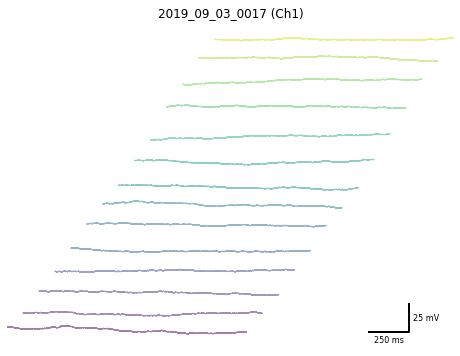

In [24]:
# plot all files with errors
for i, row in error_df.iterrows():
    abf = pyabf.ABF(row.path)
    stim_chan = abf.dacNames[1]
    resp_chan = abf.adcNames[0]
    pyabf.plot.sweeps(abf, offsetXsec=.1, offsetYunits=20, startAtSec=0, endAtSec=1.5, channel=0)
    pyabf.plot.scalebar(abf, hideFrame=True)

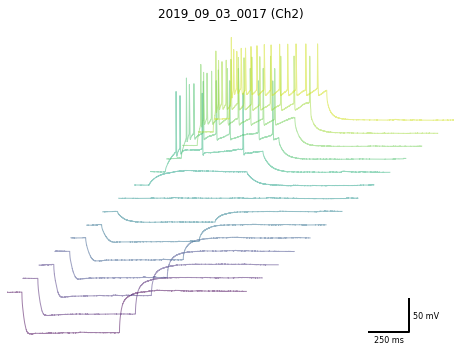

In [25]:
# plot all files with errors
for i, row in error_df.iterrows():
    abf = pyabf.ABF(row.path)
    stim_chan = abf.dacNames[1]
    resp_chan = abf.adcNames[0]
    pyabf.plot.sweeps(abf, offsetXsec=.1, offsetYunits=20, startAtSec=0, endAtSec=1.5, channel=1)
    pyabf.plot.scalebar(abf, hideFrame=True)

In [26]:
error_info = to_convert[to_convert.file_id == error_df.loc[0, 'file_id']].reset_index()

In [27]:
output_dir = Path("data/processed/test_errors_recordings")
output_dir.mkdir(exist_ok=True)

In [28]:
for i, file_info in error_info.iterrows():
    abf = pyabf.ABF(file_info.path)
    try:
        file_stem = file_info.file_id
        stim_chan = abf.adcNames[0] #'I_clampsec'
        resp_chan = abf.dacNames[1] #'Vm_sec'

        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_comments}',
                'species': 'Homo sapiens',
                'subject_id': f'Donor_{file_info.file_id}'
            }
        }


        output_path = output_dir / f'{file_stem}.nwb'
        nwb = ABF2Converter.ABF2Converter(file_info.path, str(output_path), includeChannelList=[resp_chan], stimulus_name=stim_chan, metadata=meta)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')

    except (ValueError, IndexError, TypeError, KeyError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Sep_03-2019/C1_L2/Intrinsic Properties_C1_L2/2019_09_03_0017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset None, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:627: UserWarning: The channel settings ['I_clampsec'] (included) and None (discarded) resulted in an empty channelList for /Users/derek_howard/triplab/testingephys/nwb_co

NWB Conversion complete for 2019_09_03_0017.nwb



In [29]:
!dandi validate "data/processed/test_errors_recordings"

2021-06-01 16:35:56,275 [    INFO] data/processed/test_errors_recordings/2019_09_03_0017.nwb: ok
Summary: No validation errors among 1 file(s)
2021-06-01 16:35:56,275 [    INFO] Logs saved in /Users/derek_howard/Library/Logs/dandi-cli/20210601203552Z-44749.log
